# Healthy Ride Data Exploration

<img src='https://healthyridepgh.com/wp-content/uploads/sites/3/2016/09/Healthy-Ride-Logo.Stacked-01.png' width='50%'>

<big><big><big>PGH Data Science Meetup</big></big></big>

<b>Show and Tell</b>

*December 6, 2017*

* Robert Lucente, *Pipeline*
* Chris Sternberger, *BAE Systems*
* Melinda Angeles, *Allegheny County*
* <u>Albert DeFusco</u>, *Anaconda, Inc.*

# Table of Contents
* [Healthy Ride Data Exploration](#Healthy-Ride-Data-Exploration)
	* [Get Data](#Get-Data)
	* [2016 Rides](#2016-Rides)
	* [Stations](#Stations)
	* [Harmonizing](#Harmonizing)
		* [Geocoding](#Geocoding)
	* [Again for 2017](#Again-for-2017)
	* [Popular Stations](#Popular-Stations)
		* [Cleaning](#Cleaning)
	* [Mapping](#Mapping)
	* [Ride difficulty](#Ride-difficulty)
		* [elevation](#elevation)
		* [distance](#distance)
		* [Grade](#Grade)
	* [More Google APIs](#More-Google-APIs)
		* [On time arrival](#On-time-arrival)


## Get Data

We'll do a little web scraping here to get the Zip files.

In [1]:
import os
import shutil

if os.path.exists('./data'):
    shutil.rmtree('./data/')
    
os.mkdir('./data')

<big><big>[Requests: HTTP for Humans](http://docs.python-requests.org/en/master/)</big></big> | <big><big>[BeautifulSoup: HTML parsing](https://www.crummy.com/software/BeautifulSoup/)</big></big>
:-------------------------:|:-------------------------:
<img src='http://docs.python-requests.org/en/master/_static/requests-sidebar.png' width='20%'>  |  <img src='https://singbookswithemily.files.wordpress.com/2015/03/beautiful-soup-can-w-mock-turtle-coin.jpg' width='40%'>

In [2]:
import requests
from bs4 import BeautifulSoup
from os.path import basename, join

response = requests.get('http://healthyridepgh.com/data')
soup = BeautifulSoup(response.content, 'lxml')

buttons = soup.find_all('a', attrs={'class':'btn btn-primary'})
links = [b.get('href') for b in buttons]

for link in links:
    response = requests.get(link)
    if response.ok:
        fname = basename(link)
        print('Downloading {}'.format(fname))
        with open(join('data',fname), 'wb') as f:
            f.write(response.content)

os.listdir('./data')

['HealthyRideTripData2016Q1.zip',
 'HealthyRideTripData2016Q2.zip',
 'HealthyRideTripData2016Q3.zip',
 'HealthyRideTripData2016Q4.zip',
 'HealthyRideTripData2017Q2.zip',
 'HealthyRideTripData2015Q3.zip',
 'HealthyRideTripData2017Q1.zip',
 'HealthyRideTripData2015Q2.zip',
 'HealthyRideTripData2015Q4.zip']

Finally, we'll extract the archives.

In [3]:
from zipfile import ZipFile

for file in os.listdir('./data'):
    with ZipFile(join('./data',file)) as z:
        z.extractall('./data')

In [4]:
for root, dirs, files in os.walk('./data'):
    if not dirs:
        print(root+'/')
        for f in files:
            print(' '*14,f)

./data/2017-Q1/
               Healthy Ride Rentals 2017-Q1.csv
               HealthyRideStations2017.csv
               desktop.ini
./data/2016-Q1/
               HealthyRide Rentals 2016 Q1.csv
               HealthyRideStations2016.csv
               desktop.ini
./data/2015-Q2/
               HealthyRideStations2015.csv
               HealthyRide Rentals 2015 Q2.csv
               desktop.ini
./data/2015-Q3/
               HealthyRideStations2015.csv
               HealthyRide Rentals 2015 Q3.csv
               desktop.ini
./data/2015-Q4/
               HealthyRideStations2015.csv
               HealthyRide Rentals 2015 Q4.csv
               desktop.ini
./data/2017-Q2/
               Healthy Ride Rentals 2017-Q2.csv
               HealthyRideStations2017.csv
./data/2016-Q2/
               HealthyRide Rentals 2016 Q2.csv
               HealthyRideStations2016.csv
               desktop.ini
./data/2016-Q3/
               HealthyRide Rentals 2016 Q3.csv
               HealthyRideStati

## 2016 Rides


<img src='https://pandas.pydata.org/_static/pandas_logo.png' width='80%'>

http://pandas.pydata.org

"Python and data analysis" and "panel data"

Read all of the 2016 data into a single Pandas DataFrame object it's only 70,000 rows.

In [5]:
import pandas as pd
from glob import glob
pd.options.display.max_rows = 8

files = glob('./data/2016-Q*/HealthyRide Rentals 2016 Q*.csv')
rides2016 = pd.concat([pd.read_csv(f) for f in files], ignore_index=True)

for c in 'Starttime','Stoptime':
    rides2016[c] = pd.to_datetime(rides2016[c], format='%m/%d/%Y %H:%M')
    
rides2016.head()

,Trip id,Starttime,Stoptime,Bikeid,Tripduration,From station id,From station name,To station id,To station name,Usertype
0,15335599,2016-01-01 01:44:00,2016-01-01 02:01:00,70294,1068,1026,Penn Ave & S Whitfield St,1032,Walnut St & College St,NaN
1,15335629,2016-01-01 02:39:00,2016-01-01 02:53:00,70360,892,1029,Alder St & S Highland Ave,1021,Taylor St & Liberty Ave,NaN
2,15336195,2016-01-01 10:02:00,2016-01-01 10:06:00,70369,245,1029,Alder St & S Highland Ave,1028,Penn Ave & Putnam St (Bakery Square),NaN
3,15336282,2016-01-01 10:39:00,2016-01-01 10:50:00,70304,683,1041,Fifth Ave & S Bouquet St,1047,S 22nd St & E Carson St,NaN
4,15336307,2016-01-01 10:51:00,2016-01-01 11:14:00,70345,1346,1047,S 22nd St & E Carson St,1002,Third Ave & Wood St,NaN


## Stations

Positions of each station are stored separately. 2017 probably has the most up to date stations.

In [6]:
stations = pd.read_csv('data/2017-Q1/HealthyRideStations2017.csv',encoding='iso-8859-1', index_col=0).sort_index()
stations

,Station Name,# of Racks,Latitude,Longitude
Station #,,,,
1000,Liberty Ave & Stanwix St,16,40.441326,-80.004679
1001,Forbes Ave & Market Square,19,40.440877,-80.003080
1002,Third Ave & Wood St,15,40.439030,-80.001860
1003,First Ave & Smithfield St (Art Institute),15,40.437200,-80.000375
...,...,...,...,...
1048,S 18th St & Sidney St,16,40.429338,-79.980684
1049,S 12th St & E Carson St,19,40.428661,-79.986358
1050,Healthy Ride Hub,2,40.461817,-79.968002
1061,33rd St and Penn Ave,2,40.462026,-79.968114


## Harmonizing

The rides file has *MORE* station IDs than are listed in the stations file.

In [7]:
from_ids = rides2016['From station id'].drop_duplicates()
to_ids = rides2016['To station id'].drop_duplicates()

station_ids = pd.concat([from_ids, to_ids]).drop_duplicates()
len(station_ids)

53

What is station 1060???

In [8]:
missing_stations = station_ids[~station_ids.isin(stations.index)].tolist()
missing_stations

[1060]

Let's go get its name.

In [9]:
missing_names = rides2016.loc[rides2016['From station id'].isin(missing_stations), 'From station name'].drop_duplicates()
missing_names

46569    Open Streets West End
Name: From station name, dtype: object

### Geocoding 

<img src='img/gmaps.png'>


Open Streets West End looks like a [temporary station](http://openstreetspgh.org/schedule-july-2016/#WABASH).

*Let's got find it!*

[GoogleMaps](https://github.com/googlemaps/google-maps-services-python) makes interacting with the API easy once you have a key.

**Note**: you will not be able to install `my_secrets`. These are my private API keys.

In [10]:
import googlemaps
from my_secrets.keys import google_gmap

c_map = googlemaps.Client(key=google_gmap)
wabash_and_main = c_map.geocode('Wabash and Main St. West End Pittsburgh, PA')[0]['geometry']['location']

In [11]:
import numpy as np

new_station = {
    'Station Name':'Open Streets West End',
    '# of Racks':np.nan,
    'Latitude':wabash_and_main['lat'],
    'Longitude':wabash_and_main['lng']
}

stations.loc[1060] = new_station

In [12]:
stations

,Station Name,# of Racks,Latitude,Longitude
Station #,,,,
1000,Liberty Ave & Stanwix St,16.0,40.441326,-80.004679
1001,Forbes Ave & Market Square,19.0,40.440877,-80.003080
1002,Third Ave & Wood St,15.0,40.439030,-80.001860
1003,First Ave & Smithfield St (Art Institute),15.0,40.437200,-80.000375
...,...,...,...,...
1049,S 12th St & E Carson St,19.0,40.428661,-79.986358
1050,Healthy Ride Hub,2.0,40.461817,-79.968002
1061,33rd St and Penn Ave,2.0,40.462026,-79.968114
1060,Open Streets West End,NaN,40.440910,-80.034810


## Again for 2017

In [13]:
files = glob('./data/2017-Q*/Healthy Ride Rentals 2017-Q*.csv')
rides2017 = pd.concat([pd.read_csv(f, encoding='iso-8859-1') for f in files], ignore_index=True)


for c in 'Starttime','Stoptime':
    rides2017[c] = pd.to_datetime(rides2017[c], format='%m/%d/%Y %H:%M')

from_ids = rides2017['From station id'].drop_duplicates()
to_ids = rides2017['To station id'].drop_duplicates()

station_ids2017 = pd.concat([from_ids, to_ids]).drop_duplicates()

<big><big><big><i>Whoa!!!</i></big></big></big>

There are 32 missing stations.

In [14]:
missing_stations = station_ids2017[~station_ids2017.isin(stations.index)]
len(missing_stations)

32

Some of these don't look like Pittsburgh stations.

Let's just ignore 2017 data for now. There are other data issues as well.

In [15]:
rides2017.loc[rides2017['From station id'].isin(missing_stations), 'From station name'].drop_duplicates().tolist()

['Transit',
 'Missing',
 'Willmar-Schwabe-Str. / Jahnallee (LVB Mobilitätsstation 9) ',
 'Hauptbahnhof / Westhalle',
 'Straßenbhf. Angerbrücke (LVB Mobilitätsstation 14) ',
 'Jahnallee / Thomasiusstr. / Denkmal',
 'Am Hallischen Tor / Brühl',
 'Schillerstr. / Universitätsstr. / Mensa',
 'Scheffelstr. / Karl-Liebknecht-Str. (LVB Mobilitätsstation 16) ',
 'nextbike IT Peter Touch',
 'S-Bhf. Gohlis (LVB Mobilitätsstation 13) ',
 'Hauptbahnhof / Westseite (LVB Mobilitätsstation 4)',
 'Nordplatz (LVB Mobilitätsstation 8)',
 'Industriestr. / Karlbrücke',
 'Lene-Voigt-Park / Albert-Schweitzer-Str.',
 'Forbes and Gist (Open Streets May 2017)',
 'Westplatz ',
 'Leipzig International School (Könneritzstr. / Alfred-Frank-Str.)',
 'Markgrafenstr. / LVB Servicecenter (LVB Mobilitätsstation 1) ',
 'nextbike IT Daniel Desk',
 'Healthy Hauler',
 'ASCEND Pittsburgh',
 'nextbike IT Elsterstr.',
 'Western Ave & Bidwell Street',
 'S Main St & Alexander St',
 'Highmark Stadium']

## Popular Stations

We'll define popularity as average daily turnover.

Turnover is the daily number of leaving bikes subtracted from the daily number of arriving bikes.

### Cleaning

A 5-minute round trip seems a little suspicious to me.

In [16]:
one_way = rides2016['From station id'] == rides2016['To station id']
five_minute = rides2016['Tripduration'] < 300

failed = one_way & five_minute
failed.sum()

1985

In [17]:
rides2016 = rides2016.loc[~failed]

In [18]:
leaving  = rides2016.groupby(['From station id', pd.Grouper(key='Starttime', freq='D')])['Trip id'].count()
arriving = rides2016.groupby(['To station id',   pd.Grouper(key='Stoptime' , freq='D')])['Trip id'].count()

leaving.index.names = arriving.index.names = ['station', 'date']

turnover = (arriving - leaving).mean(level='station')
turnover.name = 'turnover'
turnover.head()

station
1000    1.680782
1001    2.519355
1002   -0.248000
1003    0.068259
1004   -0.278169
Name: turnover, dtype: float64

In [19]:
stations2016 = stations.join(turnover)
stations2016

,Station Name,# of Racks,Latitude,Longitude,turnover
Station #,,,,,
1000,Liberty Ave & Stanwix St,16.0,40.441326,-80.004679,1.680782
1001,Forbes Ave & Market Square,19.0,40.440877,-80.003080,2.519355
1002,Third Ave & Wood St,15.0,40.439030,-80.001860,-0.248000
1003,First Ave & Smithfield St (Art Institute),15.0,40.437200,-80.000375,0.068259
...,...,...,...,...,...
1049,S 12th St & E Carson St,19.0,40.428661,-79.986358,0.208075
1050,Healthy Ride Hub,2.0,40.461817,-79.968002,-0.025641
1061,33rd St and Penn Ave,2.0,40.462026,-79.968114,-0.500000
1060,Open Streets West End,NaN,40.440910,-80.034810,-9.000000


## Mapping

<img src='https://www.fullstackpython.com/img/logos/bokeh.jpg' width='60%'>

*[Bokeh](https://bokeh.pydata.org/en/latest/) is a Python interactive visualization library that targets modern web browsers for presentation.*

First a little transformation I want to plot
* Every bike station
* The radius of each glyph is the absolute value of `'turnover'`
* The color indicates positive and negative

In [20]:
def scale(series):
    a = series.abs()
    return a / a.max() * 100

stations2016['size'] = scale(stations2016['turnover'])
stations2016['color'] = np.sign(stations2016['turnover']).map({-1:'red', 1:'green'})

In [21]:
from bokeh.io import output_notebook, show
from bokeh.plotting import figure, ColumnDataSource
from bokeh.models import HoverTool, WheelZoomTool
from bokeh.tile_providers import STAMEN_TONER
output_notebook()

Loading BokehJS ...

[Map projections are not easy](https://en.wikipedia.org/wiki/Map_projection).

To plot on a map tile, we'll need to use [Web Mercator Projection](https://en.wikipedia.org/wiki/Web_Mercator).

In [22]:
from pyproj import Proj, transform
inProj = Proj(init='EPSG:4326')
outProj = Proj(init='EPSG:3857')

stations2016['x'], stations2016['y'] = transform(inProj, outProj,
                                        stations2016['Longitude'].values,
                                        stations2016['Latitude'].values)

bounds = stations2016[['Longitude','Latitude']].median()

x, y = transform(inProj, outProj,
                             bounds['Longitude'],
                             bounds['Latitude'])
edge = 2200
x_range = [x-edge,x+edge]
y_range = [y-edge,y+edge]

Use your scoll, just like Google Maps to zoom.

In [23]:
plot = figure(x_range=x_range, y_range=y_range, plot_width=700, active_scroll='wheel_zoom')
plot.axis.visible = False

source = ColumnDataSource(stations2016)
hover = HoverTool(tooltips = [('Station','@{Station Name}'),('Turnover','@turnover')])

plot.add_tile(STAMEN_TONER, alpha=0.4)
plot.circle('x','y', color='color', size='size', alpha=0.8, source=source)
plot.add_tools(hover)
show(plot)

## Ride difficulty

We'll compute the following quantities
* ride distance
* elevation change
* deviation from expected duration

### elevation

In [24]:
from my_secrets.keys import google_elev
from scipy.constants import foot

c_elev = googlemaps.Client(key=google_elev)

pos = stations2016[['Latitude','Longitude']].values.tolist()
elev = [d['elevation'] / foot for d in c_elev.elevation(pos)]

stations2016['elevation'] = elev 

### distance

[Read this](https://gis.stackexchange.com/questions/84885/whats-the-difference-between-vincenty-and-great-circle-distance-calculations) for a discussion of distance algorithms.

<img src='http://numba.pydata.org/_static/numba_blue_icon_rgb.png' width='20%' align='right'>
<big><big><big><b>[Numba](http://numba.pydata.org)</b></big></big></big>

Numba will compile the function to optimized C code (using the LLVM compiler), and it understands NumPy arrays natively.

It will also automatically generate and compile GPU kernels.

In [25]:
from geopy.distance import EARTH_RADIUS
from scipy.constants import mile
import numba

@numba.guvectorize(['(float64[:,:], float64[:,:], float64[:])'], '(n,m),(n,m)->(n)', nopython=True, target='parallel')
def _haversine(origin, destination, output):
    '''the haversine distance in miles'''
    assert origin.shape[0] == destination.shape[0]
    
    # earth radius in miles
    constant = EARTH_RADIUS * 1000/mile * 2
    p = np.pi / 180
    
    n = origin.shape[0]
    for i in range(n):
        lat1 = origin[i,0]
        lon1 = origin[i,1]
        lat2 = destination[i,0]
        lon2 = destination[i,1]
    
        a = 0.5 - np.cos((lat2 - lat1) * p) / 2  \
           + np.cos(lat1 * p) * np.cos(lat2 * p) \
           * (1 - np.cos((lon2 - lon1) * p )) / 2
        output[i] = constant * np.arcsin(np.sqrt(a))

def haversine(origin, destination):
    '''The haversine distance in miles
    
    Compute the distance in miles between arrays of origin
    and destination locations.
    
    Parameters
    ----------
    origin      : Pandas DataFrame of Latitude, Longitude positions
    destination : Pandas DataFrame of Latitude, Longitude positions
    
    Returns
    -------
    Pandas Series on the same index as origin'''
    
    # ensure that the two dataframes are
    # aligned by row and column.
    left, right = origin.align(destination, join='inner')
    
    out = np.empty(shape=left.shape[0], dtype=np.float64)
    _haversine(left.values, right.values, out)
    
    return pd.Series(out, index=left.index)

In [26]:
start = rides2016.merge(stations2016, left_on='From station id', right_index=True)
end = rides2016.merge(stations2016, left_on='To station id', right_index=True)

distances = haversine(start[['Latitude','Longitude']], end[['Latitude','Longitude']])

### Grade

In [27]:
elevation_change = end['elevation'] - start['elevation']

In [28]:
rides2016['pct_grade'] = (elevation_change / distances / 5280) * 100
pairs = rides2016.groupby(['From station name','To station name']).agg({'Trip id':'count', 'pct_grade':'first'})

Rides of extreme grade were less popular in 2016. Could be for any number of reasons.

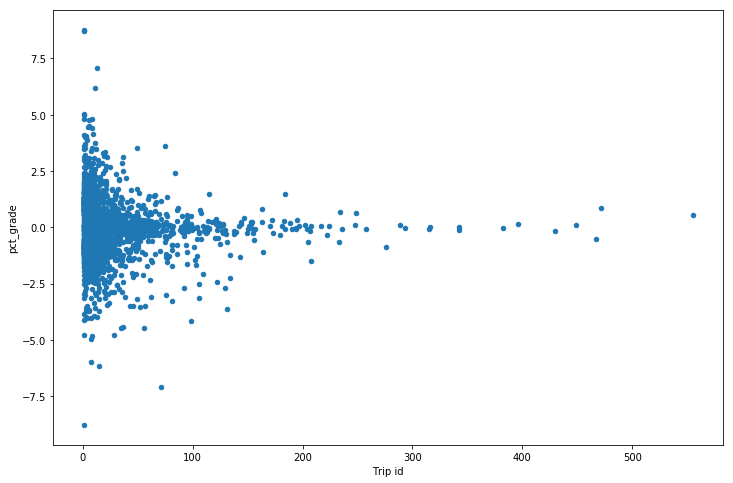

In [36]:
%matplotlib inline
pairs.plot.scatter(x='Trip id', y='pct_grade', figsize=(12,8))

In [30]:
pairs.dropna().nlargest(3, 'Trip id')

,,Trip id,pct_grade
From station name,To station name,,
Boulevard of the Allies & Parkview Ave,Fifth Ave & S Bouquet St,555,0.533499
Alder St & S Highland Ave,Penn Ave & Putnam St (Bakery Square),472,0.872817
Fifth Ave & S Bouquet St,Boulevard of the Allies & Parkview Ave,467,-0.533499


## More Google APIs

<big><big>Google Distance Matrix</big></big>
* actual *biking* distance
* expected time

In [31]:
# cooking show version
gmap = pd.read_csv('gmap.csv')
gmap['time'] = pd.to_timedelta(gmap['time'])
gmap

,From station id,To station id,Gdistance (meters),time
0,1026,1032,1068,00:03:47
1,1029,1021,2868,00:12:03
2,1029,1028,1080,00:04:27
3,1041,1047,2865,00:08:36
...,...,...,...,...
2227,1010,1042,2464,00:15:58
2228,1061,1016,2114,00:07:01
2229,1005,1033,9924,00:36:03
2230,1022,1061,2245,00:07:09


In [32]:
gmap['time'].describe()

count                      2231
mean     0 days 00:16:44.927835
std      0 days 00:09:38.167278
min             0 days 00:00:00
25%             0 days 00:08:56
50%             0 days 00:15:54
75%             0 days 00:23:55
max             0 days 00:45:19
Name: time, dtype: object

### On time arrival

I don't trust the Starttime and Stoptime columns.

In [33]:
gmap_rides = rides2016.merge(gmap)

In [34]:
gmap_rides['deviation'] = gmap_rides['Tripduration'] - gmap_rides['time'].dt.total_seconds()
gmap_rides['deviation'].describe()

count     74434.000000
mean       2923.737338
std        9404.711734
min       -1403.000000
25%          99.000000
50%         538.000000
75%        2749.000000
max      168239.000000
Name: deviation, dtype: float64

In [35]:
fast_rides = gmap_rides.loc[gmap_rides['deviation'] < 0]
fast_rides[['From station name','To station name','pct_grade','deviation']].nsmallest(5, 'deviation')

,From station name,To station name,pct_grade,deviation
69237,Fort Duquesne Blvd & 7th St,S 27th St & Sidney St. (Southside Works),0.125395,-1403.0
72691,Liberty Ave & Stanwix St,Coltart Ave & Forbes Ave,1.390559,-1367.0
73942,Third Ave & Wood St,Penn Ave & Putnam St (Bakery Square),0.816549,-1300.0
73684,Liberty Ave & Stanwix St,S Negley Ave & Baum Blvd,0.797791,-1257.0
72782,S 22nd St & E Carson St,42nd & Penn Ave.,1.234573,-1180.0
